In [29]:
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys

sys.path.append("/Users/adam/Projects/WUT/MatUnder/project/NarAda/jmi.py")

In [108]:

from jmi import jmi_method
from cmim import cmim_method
from sklearn.preprocessing import OrdinalEncoder
import datasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [55]:
feature_selectors = {
    'RandomForest': SelectFromModel(RandomForestClassifier(n_estimators=100), threshold=-np.inf),
    'DecisionTreeClassifier': SelectFromModel(DecisionTreeClassifier()),
    'LogisticRegression': SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), threshold=-np.inf),
    'F_classif': SelectKBest(score_func=f_classif),
    'jmi': SelectKBest(score_func=jmi_method),
    'cmim': SelectKBest(score_func=cmim_method),
    'Mutual_info': SelectKBest(score_func=mutual_info_classif)
}

In [129]:
def run_experiments(X, y, seeds=None):
    try:
        X = X.values
    except:
     pass
    if seeds is None:
        seeds = [42]
    # Results dictionary
    results = {name: {'accuracy': [], 'f1': [], "selected_features": [], "train_accuracy": []} for name in feature_selectors.keys()}
    
    # Experiment loop
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        
        for name, selector in feature_selectors.items():
            accuracies = []
            f1_scores = []
            selected_features = []
            train_accuracies = []
            cmim = None
            for k in range(1, n_features + 1):
                if name == "cmim":
                    if cmim is None:
                        cmim = True
                        features = cmim_method(X_train, y_train, X_train.shape[1])
                    select = features[:k]
                    X_train_temp = X_train[:, features[:k]]
                    X_test_temp = X_test[:, features[:k]]
                    lr = LogisticRegression()
                    lr.fit(X_train_temp, y_train)
                    train_acc = lr.score(X_train_temp, y_train)
                    acc = lr.score(X_test_temp, y_test)
                    predictions = lr.predict(X_test_temp)
                    f1 = f1_score(y_test, predictions, average='macro')
                    accuracies.append(acc)
                    f1_scores.append(f1)
                    selected_features.append(select)
                    train_accuracies.append(train_acc)
                elif 'SelectKBest' in str(type(selector)):
                    selector.k = k
                else:
                    selector.max_features = k
                if cmim is None:
                    pipeline = Pipeline([
                        ('select', selector),
                        ('classify', LogisticRegression())
                    ])
        
                    pipeline.fit(X_train, y_train)
                    predictions = pipeline.predict(X_test)
                    acc = pipeline.score(X_test, y_test)
                    train_acc = pipeline.score(X_train, y_train)
                    select = pipeline["select"].get_feature_names_out()
                
                    
                    f1 = f1_score(y_test, predictions, average='macro')
    
                    accuracies.append(acc)
                    f1_scores.append(f1)
                    selected_features.append(select)
                    train_accuracies.append(train_acc)
                
            results[name]['accuracy'].append(accuracies)
            results[name]['f1'].append(f1_scores)
            results[name]["selected_features"].append(selected_features)
            results[name]['train_accuracy'].append(train_accuracies)
    # Calculate average results
    avg_results = {name: {'accuracy': np.mean(metrics['accuracy'], axis=0), 'f1': np.mean(metrics['f1'], axis=0), "selected_features": metrics["selected_features"], "train_accuracy": metrics["train_accuracy"]}
                   for name, metrics in results.items()}
    return avg_results

# Real Data

## Breast Cancer

In [230]:
data = load_breast_cancer()
X = data.data
y = data.target
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X = discretizer.fit_transform(X)
y = LabelEncoder().fit_transform(y)
n_features = 20

30


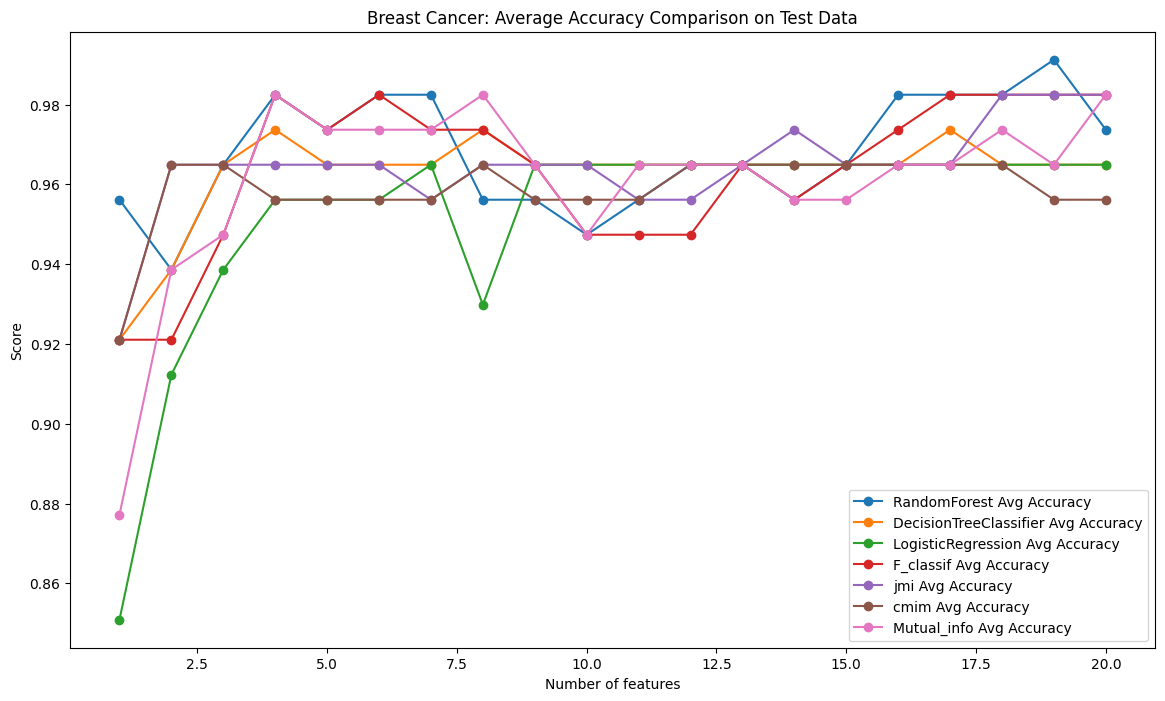

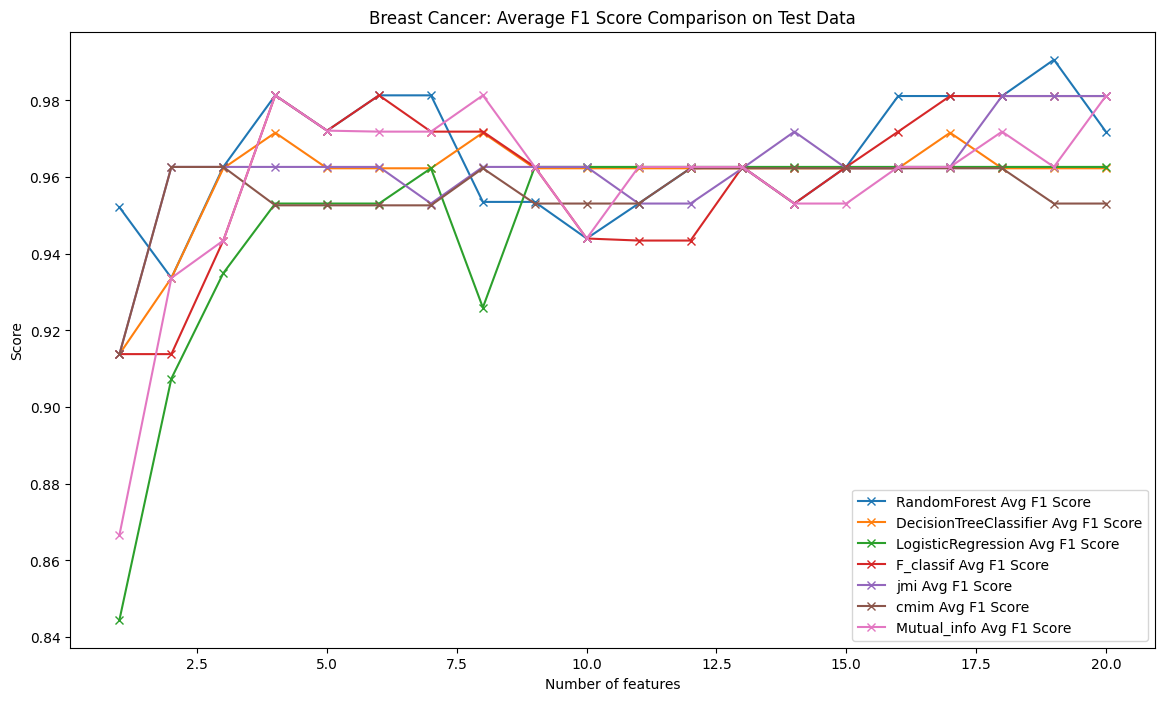

In [231]:
avg_results_cancer = run_experiments(X, y)
plt.figure(figsize=(14, 8))
for name, metrics in avg_results_cancer.items():
    plt.plot(range(1, n_features + 1), metrics['accuracy'], marker='o', linestyle='-', label=f'{name} Avg Accuracy')

plt.title('Breast Cancer: Average Accuracy Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./breast_cancer_acc.jpg", dpi=200)
plt.show()

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_cancer.items():
    plt.plot(range(1, n_features + 1), metrics['f1'], marker='x', label=f'{name} Avg F1 Score')
plt.title('Breast Cancer: Average F1 Score Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./breast_cancer_f1.jpg", dpi=200)
plt.show()

0.941
1


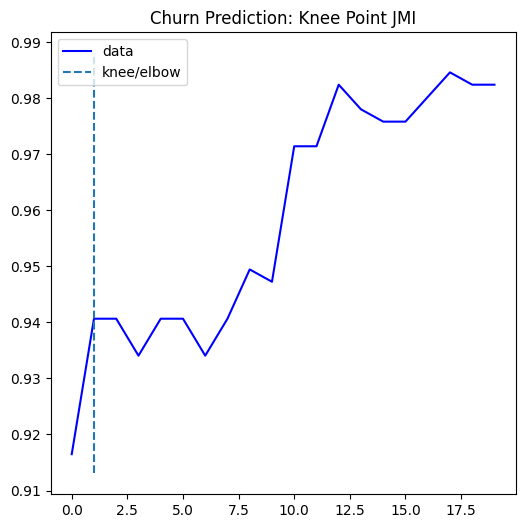

In [263]:
from kneed import KneeLocator

data = np.mean(avg_results_cancer["jmi"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave", direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Churn Prediction: Knee Point JMI")
plt.savefig("knee_churn_jmi.jpg", dpi=200)

0.967
3


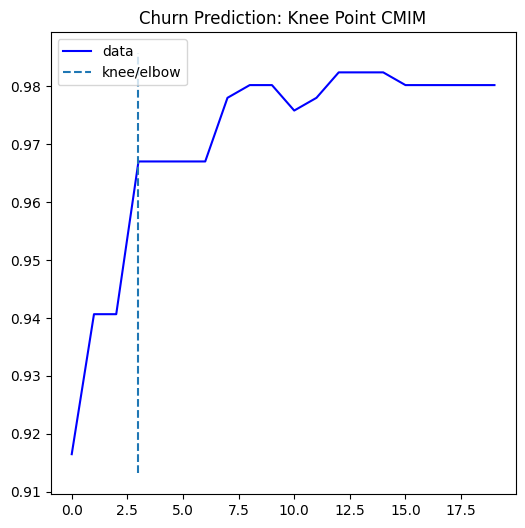

In [256]:
from kneed import KneeLocator

data = np.mean(avg_results_cancer["cmim"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave", direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Churn Prediction: Knee Point CMIM")
plt.savefig("knee_churn_cmim.jpg", dpi=200)

## scikit-learn/churn-prediction

In [190]:
dataset = datasets.load_dataset("scikit-learn/churn-prediction")
df = dataset["train"].with_format("pandas")[:]
y = df.loc[:, "Churn"]
X = df.iloc[:, 1:-1]
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
float_cols = X.select_dtypes(include=['float']).columns.to_list()
float_cols.append("TotalCharges")
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X[float_cols] = discretizer.fit_transform(X[float_cols])
y = LabelEncoder().fit_transform(y)
n_features = 15

19


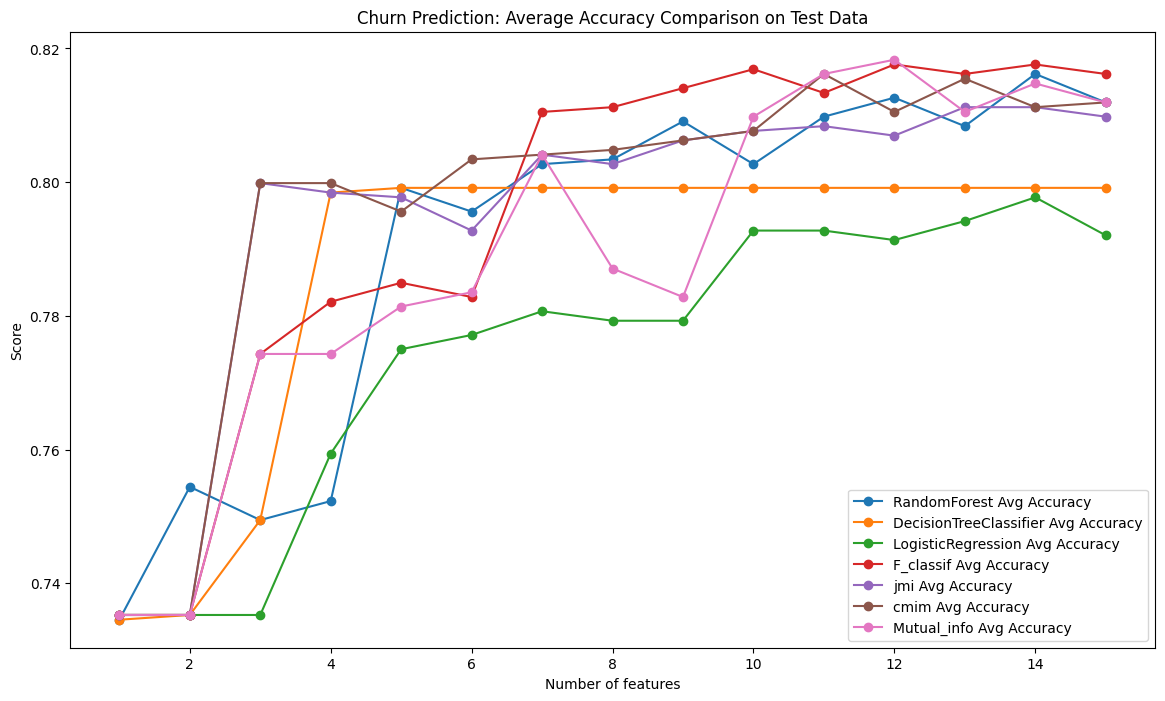

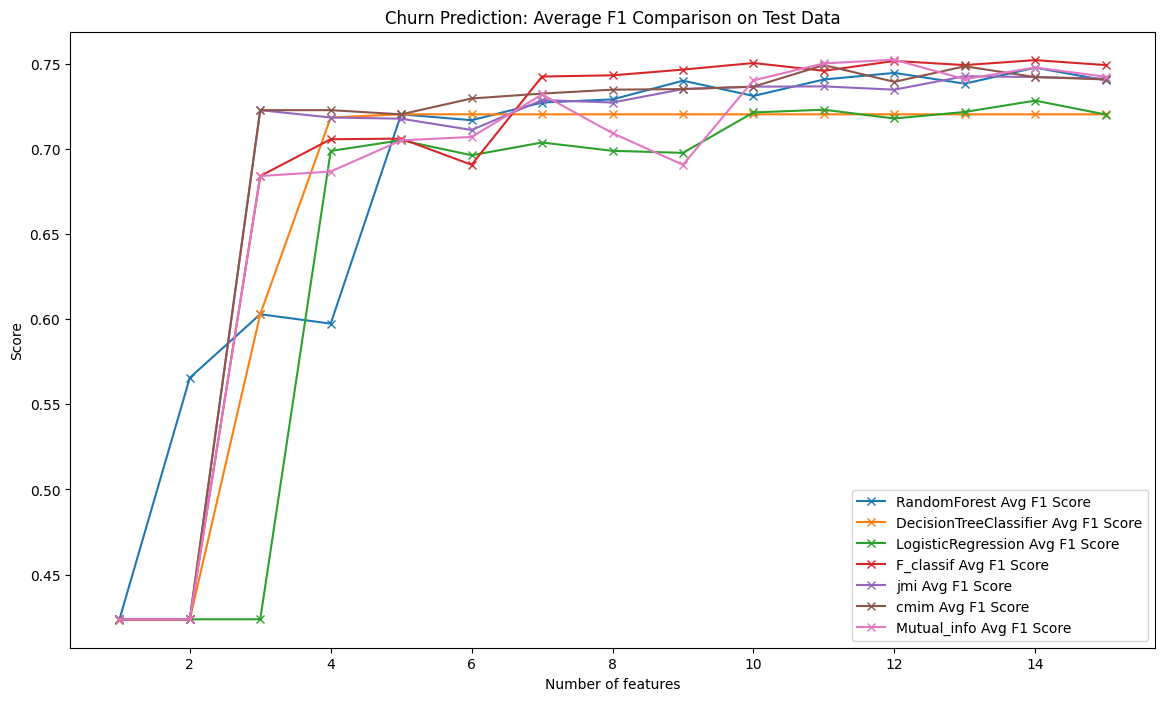

In [191]:
avg_results_churn = run_experiments(X, y)
# Plotting average results
plt.figure(figsize=(14, 8))
for name, metrics in avg_results_churn.items():
    plt.plot(range(1, n_features + 1), metrics['accuracy'], marker='o', linestyle='-', label=f'{name} Avg Accuracy')

plt.title('Churn Prediction: Average Accuracy Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./churn_acc.jpg", dpi=200)
plt.show()


plt.figure(figsize=(14, 8))
for name, metrics in avg_results_churn.items():
    plt.plot(range(1, n_features + 1), metrics['f1'], marker='x', label=f'{name} Avg F1 Score')
plt.title('Churn Prediction: Average F1 Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./churn_f1.jpg", dpi=200)
plt.show()


0.786
2


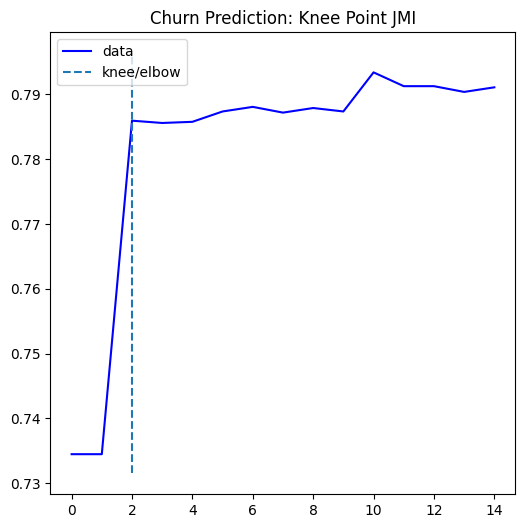

In [253]:
from kneed import KneeLocator

data = np.mean(avg_results_churn["jmi"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave", direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Churn Prediction: Knee Point JMI")
plt.savefig("knee_churn_jmi.jpg", dpi=200)

0.786
2


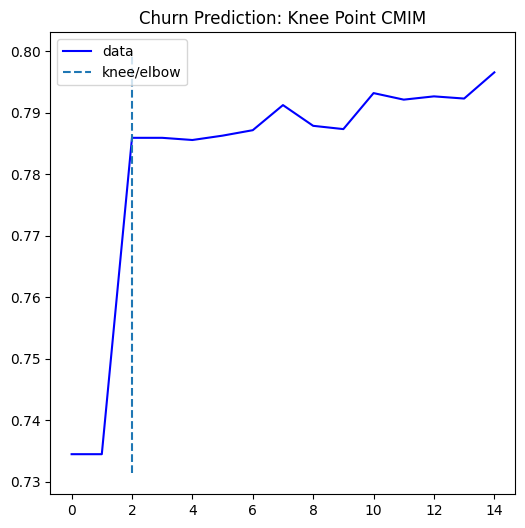

In [254]:
from kneed import KneeLocator

data = np.mean(avg_results_churn["cmim"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave", direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Churn Prediction: Knee Point CMIM")
plt.savefig("knee_churn_cmim.jpg", dpi=200)

# scikit-learn/credit-card-clients

In [152]:
from datasets import load_dataset

dataset = load_dataset("scikit-learn/credit-card-clients")
df = dataset["train"].with_format("pandas")[:]
y = df.loc[:, "default.payment.next.month"]
X = df.iloc[:, 1:-1]
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
float_cols = X.select_dtypes(include=['float']).columns.to_list()
for a in ["AGE", "BILL_AMT1", "BILL_AMT4"]:
    float_cols.append(a)
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X[float_cols] = discretizer.fit_transform(X[float_cols])

y = LabelEncoder().fit_transform(y)

23


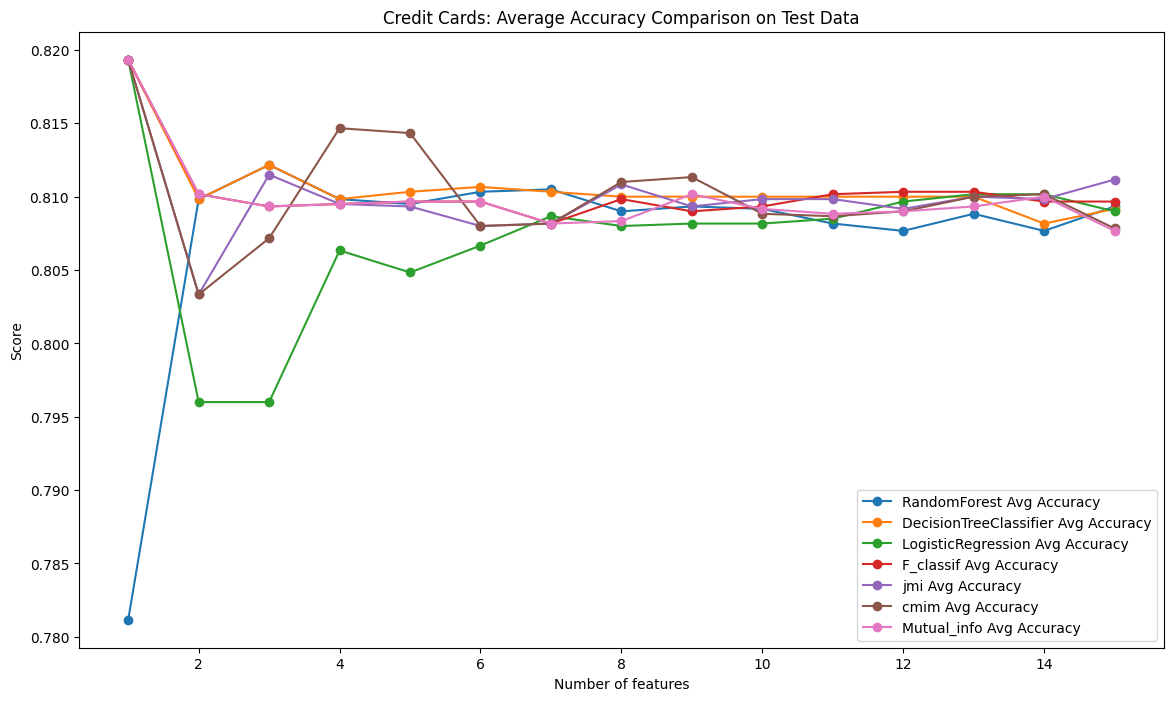

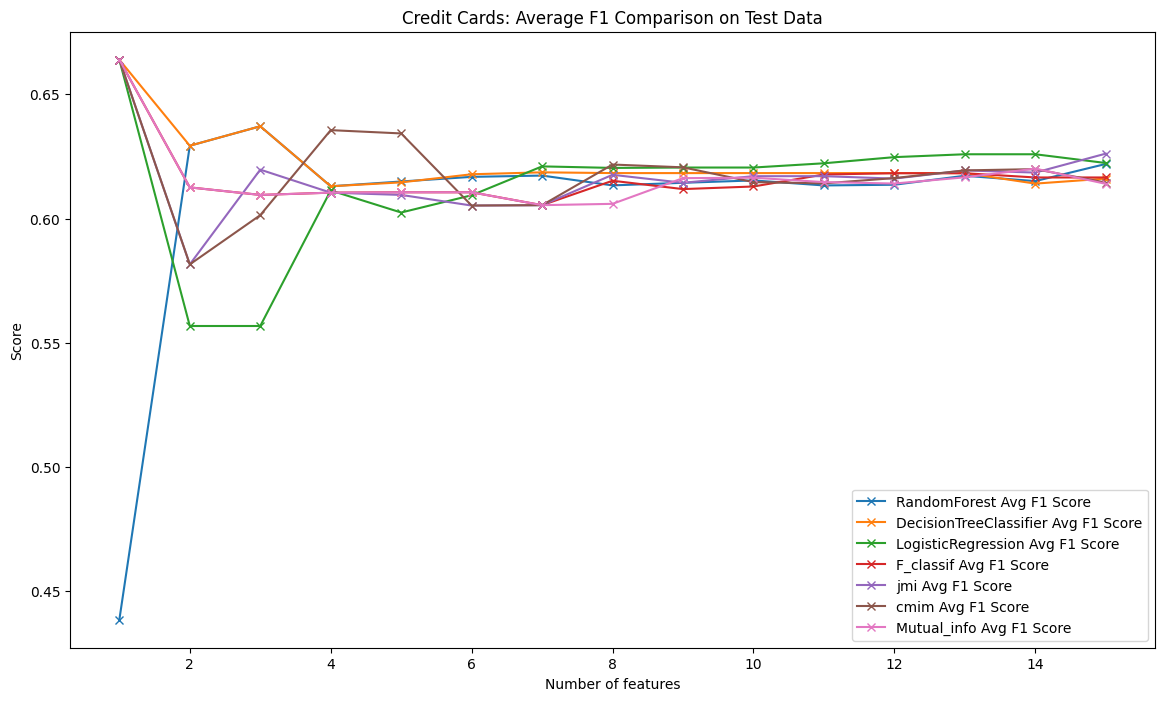

In [159]:
n_features = 15

avg_results_credit = run_experiments(X, y)
# Plotting average results
plt.figure(figsize=(14, 8))
for name, metrics in avg_results_credit.items():
    plt.plot(range(1, n_features + 1), metrics['accuracy'], marker='o', label=f'{name} Avg Accuracy')

plt.title('Credit Cards: Average Accuracy Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./credit_card_acc.jpg", dpi=200)
plt.show()

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_credit.items():
    plt.plot(range(1, n_features + 1), metrics['f1'], marker='x', label=f'{name} Avg F1 Score')
plt.title('Credit Cards: Average F1 Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./credit_card_f1.jpg", dpi=200)
plt.show()

0.786
2
0.786
2


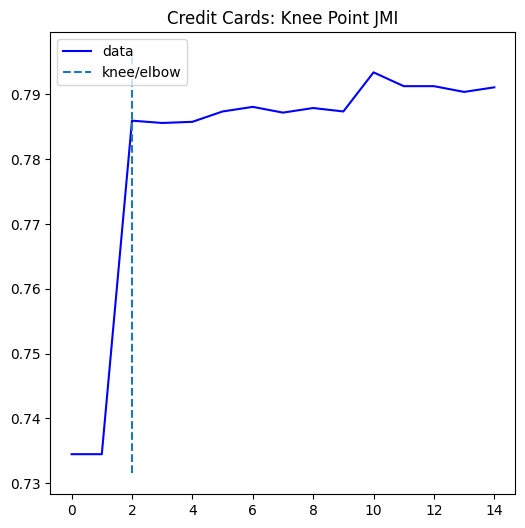

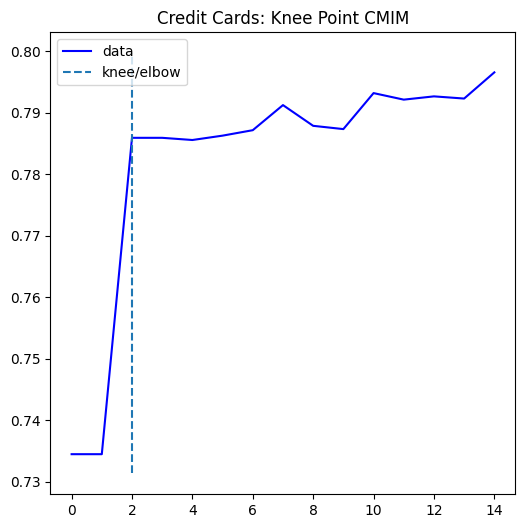

In [264]:
from kneed import KneeLocator

data = np.mean(avg_results_churn["jmi"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave",
                      direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Credit Cards: Knee Point JMI")
plt.savefig("knee_credit_jmi.jpg", dpi=200)
from kneed import KneeLocator

data = np.mean(avg_results_churn["cmim"]['train_accuracy'], axis=0)
kneedle = KneeLocator(range(len(data)), data, S=1.0, curve="concave",
                      direction="increasing")

print(round(kneedle.knee_y, 3))

print(round(kneedle.elbow, 3))
kneedle.plot_knee()
plt.title("Credit Cards: Knee Point CMIM")
plt.savefig("knee_credit_cmim.jpg", dpi=200)

# Artificial Datasets

## XOR

In [265]:
def xor_dataset(n=1000):
    x = np.random.binomial(1, 0.5, (n, 2))
    irr_x = np.random.normal(loc=0, scale=1, size=(n, 3))
    y = np.logical_xor(x[:, 0], x[:, 1]).astype(int)
    X = np.concatenate([x, irr_x], axis=1)
    return X, y

In [266]:
X, y = xor_dataset()

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


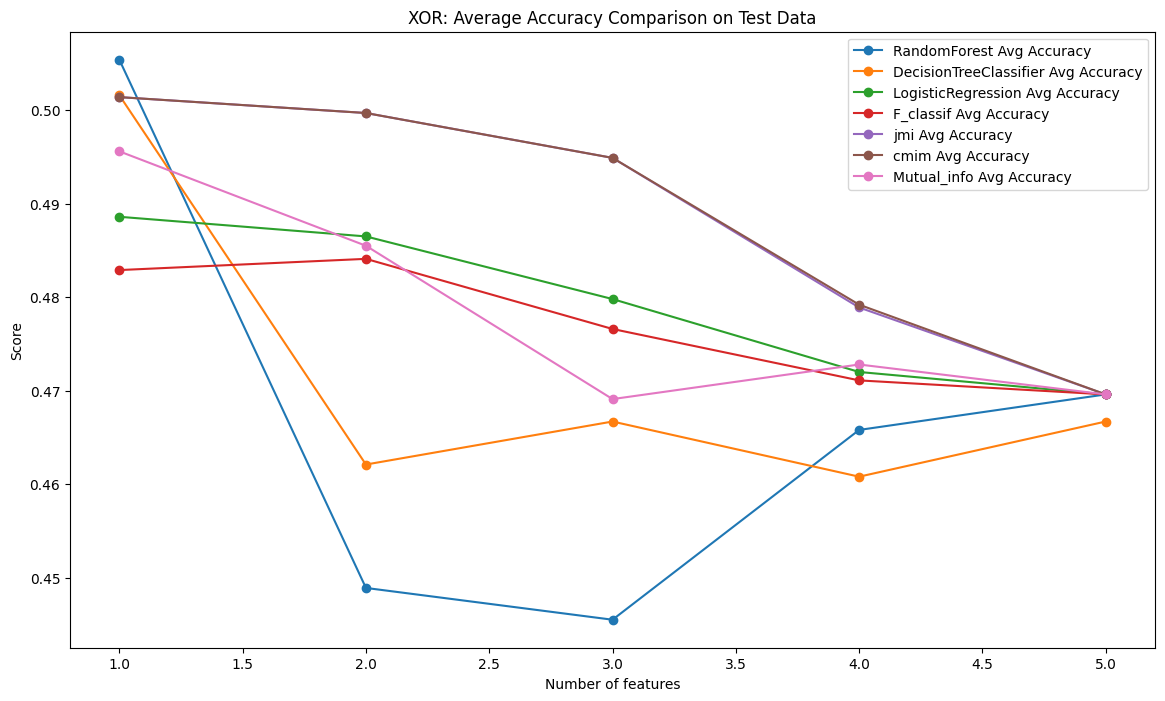

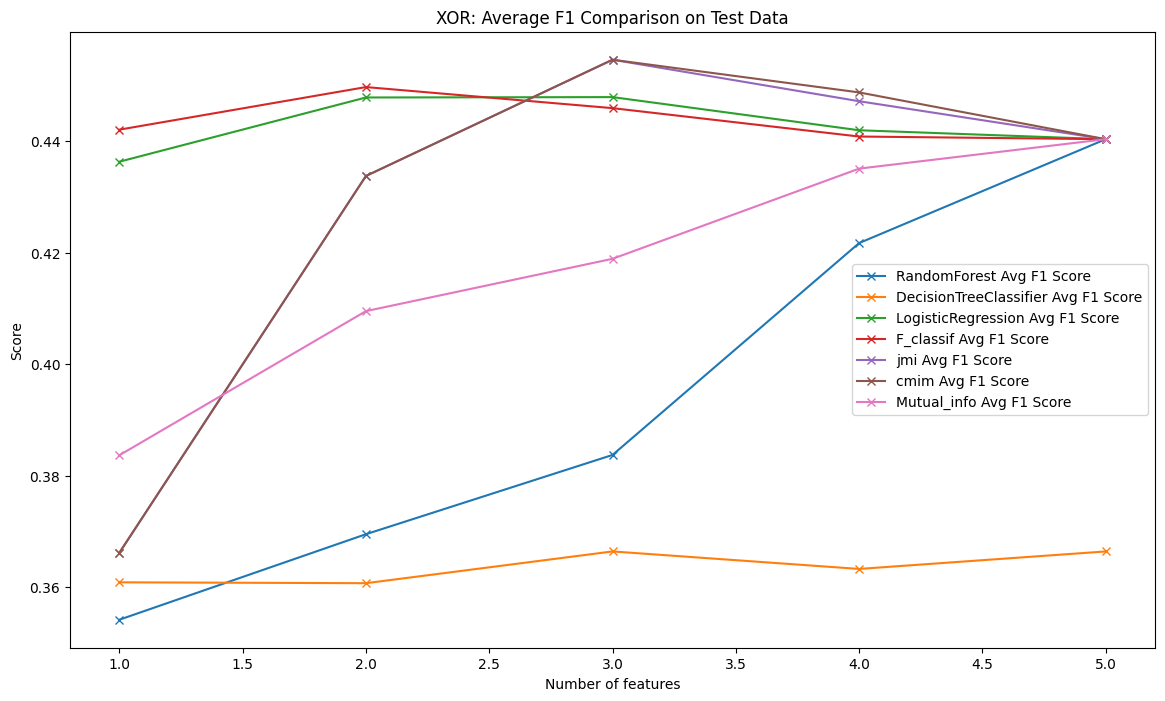

In [267]:

float_cols = [2,3,4]
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X[:, float_cols] = discretizer.fit_transform(X[:, float_cols])

X = discretizer.fit_transform(X)
n_features = 5

avg_results_xor = run_experiments(X, y, seeds=list(range(50)))

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_xor.items():
    plt.plot(range(1, n_features + 1), metrics['accuracy'], marker='o', label=f'{name} Avg Accuracy')

plt.title('XOR: Average Accuracy Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./xor_acc.jpg", dpi=200)
plt.show()

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_xor.items():
    plt.plot(range(1, n_features + 1), metrics['f1'], marker='x', label=f'{name} Avg F1 Score')
plt.title('XOR: Average F1 Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./xor_f1.jpg", dpi=200)
plt.show()

In [235]:
data = avg_results_xor['jmi']["selected_features"]
count = 0
for group in data:
    for sub_array in group:
        if list(sub_array) == ['x0', 'x1']:
            count += 1
print("Two correctly used features")
print(count)
count = 0
for group in data:
    for sub_array in group:
        if len(list(sub_array)) ==2 and  ("x0" in  list(sub_array) or "x1" in list(sub_array)):
            count += 1
print("At least one correctly predicted")
print(count)

data = avg_results_xor['cmim']["selected_features"]
count = 0
for group in data:
    for sub_array in group:
        if list(sub_array) == [0, 1]:
            count += 1
print("Two correctly used features")
print(count)
count = 0
for group in data:
    for sub_array in group:
        if len(list(sub_array)) ==2 and  (0 in  list(sub_array) or 1 in list(sub_array)):
            count += 1
print("At least one correctly predicted")
print(count)

Two correctly used features
0
At least one correctly predicted
0
Two correctly used features
0
At least one correctly predicted
0


In [236]:
data

[[[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 1], [3, 2, 4, 1, 0]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[2], [2, 3], [2, 3, 4], [2, 3, 4, 0], [2, 3, 4, 0, 1]],
 [[2], [2, 3], [2, 3, 4], [2, 3, 4, 0], [2, 3, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 1], [3, 2, 4, 1, 0]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2], [3, 2, 4], [3, 2, 4, 0], [3, 2, 4, 0, 1]],
 [[3], [3, 2],

## Linear Combination

In [268]:
def linear_comb_dataset(n=1000):
    x = np.random.normal(0, 1, (n, 2))
    
    x_irr = np.random.normal(2, 3, size=(n, 2))
    x_irr2 = np.random.normal(4, 2, size=(n, 1))

    y = 3 * x[:, 0] - 2 * x[:, 1] + np.random.normal(0, 0.5, n)
    X = np.concatenate([x, x_irr, x_irr2], axis=1)
    return X, y

In [269]:
X, y = linear_comb_dataset()

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


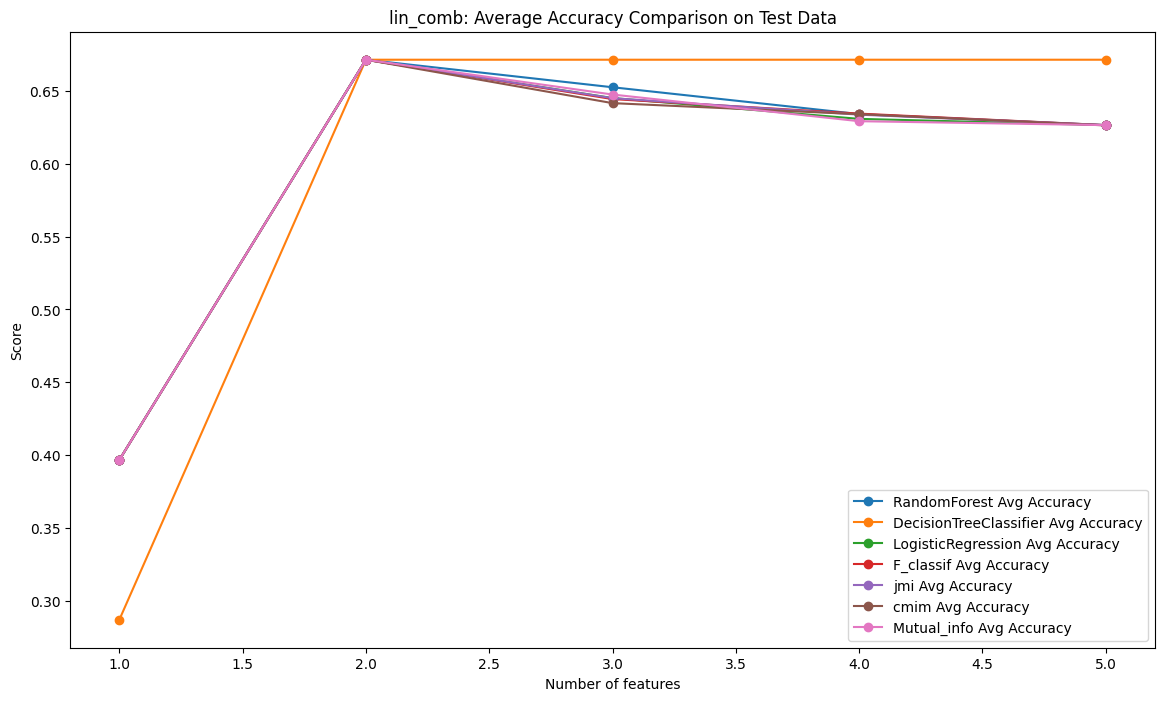

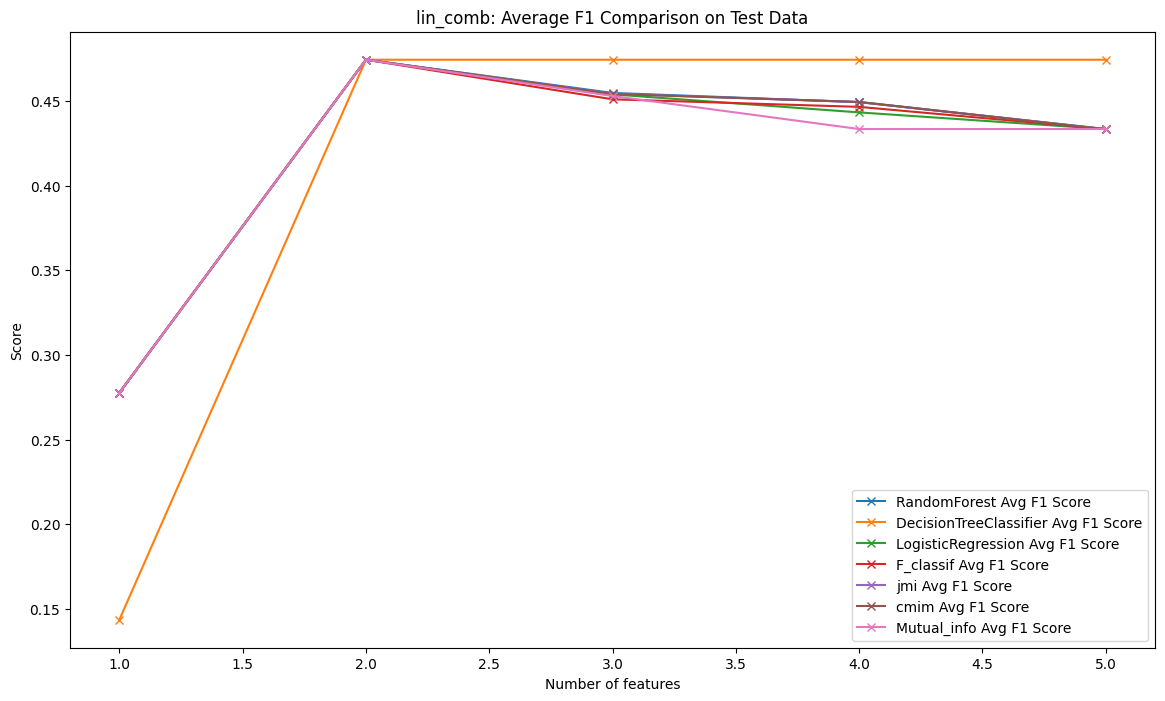

In [270]:

float_cols = [0, 1, 2, 3, 4]
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X[:, float_cols] = discretizer.fit_transform(X[:, float_cols])
discretizer2 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
y = discretizer2.fit_transform(y.reshape(-1, 1)).flatten()
X = discretizer.fit_transform(X)
n_features = 5

avg_results_lin_comb = run_experiments(X, y, seeds=list(range(50)))

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_lin_comb.items():
    plt.plot(range(1, n_features + 1), metrics['accuracy'], marker='o', label=f'{name} Avg Accuracy')

plt.title('lin_comb: Average Accuracy Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./lin_comb_acc.jpg", dpi=200)
plt.show()

plt.figure(figsize=(14, 8))
for name, metrics in avg_results_lin_comb.items():
    plt.plot(range(1, n_features + 1), metrics['f1'], marker='x', label=f'{name} Avg F1 Score')
plt.title('lin_comb: Average F1 Comparison on Test Data')
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend()
plt.savefig("./lin_comb_f1.jpg", dpi=200)
plt.show()

In [240]:
data = avg_results_lin_comb['jmi']["selected_features"]
count = 0
for group in data:
    for sub_array in group:
        if list(sub_array) == ['x0', 'x1']:
            count += 1
print("Two correctly used features")
print(count)
count = 0
for group in data:
    for sub_array in group:
        if len(list(sub_array)) ==2 and  ("x0" in  list(sub_array) or "x1" in list(sub_array)):
            count += 1
print("At least one correctly predicted")
print(count)

data = avg_results_lin_comb['cmim']["selected_features"]
count = 0
for group in data:
    for sub_array in group:
        if list(sub_array) == [0, 1]:
            count += 1
print("Two correctly used features")
print(count)
count = 0
for group in data:
    for sub_array in group:
        if len(list(sub_array)) ==2 and  (0 in  list(sub_array) or 1 in list(sub_array)):
            count += 1
print("At least one correctly predicted")
print(count)

Two correctly used features
50
At least one correctly predicted
50
Two correctly used features
50
At least one correctly predicted
50
